In [1]:
# This reloads python code imported from *.py files automatically
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import tqdm 
import tqdm.notebook

from optimization import *

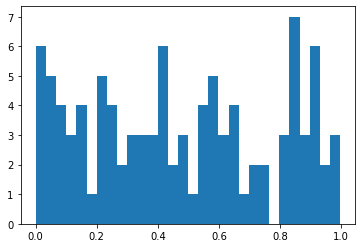

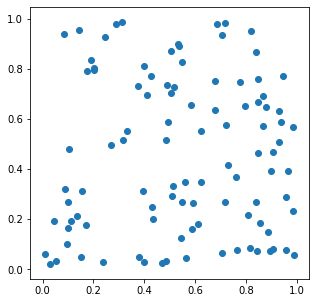

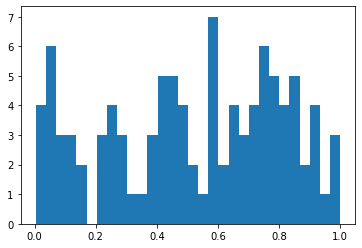

[0.49772448 0.49772448]


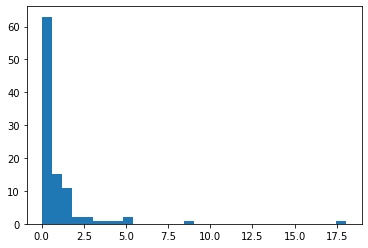

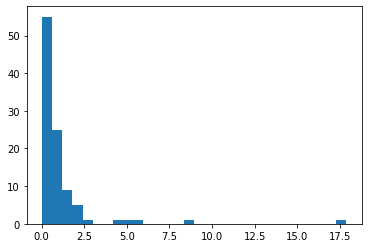

In [3]:
# Uniform distribution

g1 = G1()
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

g1.refresh() # generate a new dataset
plt.hist(g1.v, bins=30)
plt.show()

m = np.array([0., 0.])

for _ in range(10):
  g1.refresh() # refresh the dataset
  m  += 0.1*g1.x.mean()

print(m)

# Log normal distribution
g2 = G2()
plt.hist(g2.v, bins=30)
plt.show()
g2.refresh()
plt.hist(g2.v, bins=30)
plt.show()

---

In [27]:
np.random.seed(42)
n_iter = 20000

# parametersc
l = 0.8 # lambda in [0,1]
beta = 25

# initialization
N = 100
n_selected = 0
g = G1(N)
# g = G2(N)
citiesX = g.x
citiesV = g.v


In [ ]:
# Run the optimization to compute the selected cities
np.random.seed(52)
all_selected_cities, selected_cities_n_convex, loss_values,loss_values_convex = optimize(g, l, beta=beta, 
                                          n_iter=n_iter,mutation_strategy=0,
                                          precompute_pairwise_dist=False, verbose=True)

if type(all_selected_cities) == list:
    selected_cities_n = all_selected_cities[-1]
print(selected_cities_n)
print('Final loss '+ str(loss_values[n_iter-1]))
print('Final loss convex'+ str(loss_values_convex))
plt.figure()
plt.plot(np.arange(n_iter), loss_values);

plt.figure()
m = selected_cities_n == 1
mbis = (selected_cities_n_convex==1) & (selected_cities_n==0)
mter = (selected_cities_n_convex==0) & (selected_cities_n==1)
plt.scatter(g.x[:, 0], g.x[:, 1])
plt.scatter(g.x[m, 0], g.x[m, 1], c='r')
plt.scatter(g.x[mbis, 0], g.x[mbis, 1], c='g')
plt.scatter(g.x[mter, 0], g.x[mter, 1], c='y')
plt.xlim(0, 1)
plt.ylim(0, 1)


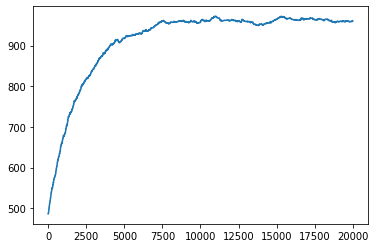

In [26]:
num_cities_per_step = np.array(all_selected_cities).sum(axis=1)
plt.plot(np.arange(n_iter), num_cities_per_step)

**Discussion:**
* convergence in terms of beta ?
* Choice of beta? Small then large, or use the optimal beta of the course (need precomputation?)
* Run the simulation many times? Then pick the min? Or do simulated annealing (with different beta)

**To be added:**
* statistics and visualization (of the cities at their location, with a color corresponding to selected or not)


In [ ]:
a = np.random.rand(10)
idx = np.zeros_like(a)
idx[1] =1
idx[5] = 1




In [ ]:
import scipy
from optimization import *

a = np.arange(16).reshape(4, 4)
a = a.T @ a
print(a)
for i in range(4):
    a[i, i] = 0
scipy.spatial.distance.squareform(a)

for i in range(6):
    print(condensed_to_square(i, 4))

